# CSV Processing and Database Upload
The following notebook reads in all files within the scraped_datasets folder, appends them together and prepares the data for database upload. From there, the scraped articles are uploaded to table <b> article </b> in SQLite database <b> capstone.db</b> along with the URL data in table <b> url </b>. When the upload is complete, the database connection is closed and the csv files are moved to the completed_datasets folder. 
<br><br>
There are no longer articles being scraped so errors may be thrown as the scraped_datasets folder is empty. At the end of the notebook, all articles that contain "opioid" are exported to a CSV file for manual labeling. 


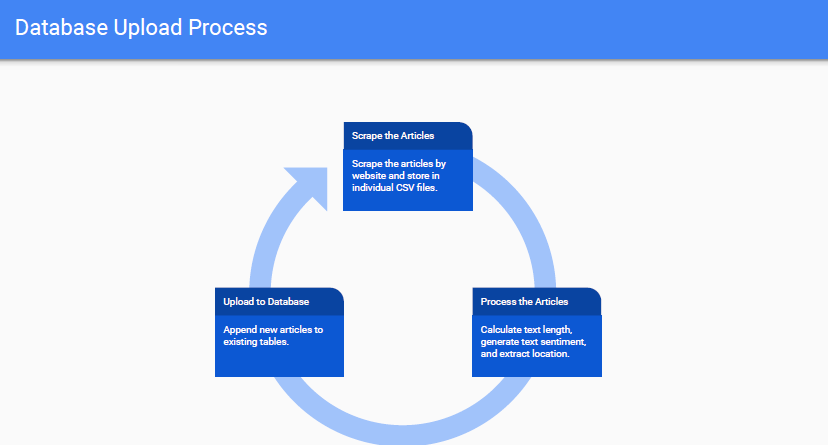

In [1]:
#import the necessary libraries 
import glob #module finds all the pathnames matching a specified pattern
import pandas as pd
import shutil #used to copy over/move files 
import sqlite3
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

In [2]:
#define the path of the csv files 
source = r'../scraped_datasets/' 
#define the path to move the csv flies after being uploaded to db 
dest = '../completed_datasets/'
#search for all csv files in scraped_dataset folder
all_files = glob.glob(source + "/*.csv")


In [3]:
#initialize a list
df_list = []

#for each file in the all_files list
for filename in all_files:
    #read in the file name without regard to csv index using the first row as a header   ,
    df = pd.read_csv(filename, index_col = 0, header=0)
    #append the dataframe to list
    df_list.append(df)

#concatenate the dataframes in df_list by the columns, the indexing does not matter, denoted to avoid unnecessary warnings
dfAll = pd.concat(df_list, axis=0, ignore_index=True, sort = False)

In [4]:
dfAll.head()

title  \
0  How I got my 89-year-old dad to crush it in th...   
1  A great L.A. Walk: Valhalla Memorial Park in N...   
2  Great L.A. Walks: Strolling Pasadena greenery ...   
3  Actor Mark Wahlberg's two-workout, seven-meal ...   
4  This hike from Mulholland Drive has panoramic ...   

                                                text  \
0  “Exercise? I get plenty going to Costco for fr...   
1  There are so few wide-open green spaces in Los...   
2  Here's an urban walk in Pasadena, easily acces...   
3  Actor Mark Wahlberg schedules everything to th...   
4  Here’s a short, simple hilltop walk off one of...   

                    website_domain  \
0  https://www.latimes.com/health/   
1  https://www.latimes.com/health/   
2  https://www.latimes.com/health/   
3  https://www.latimes.com/health/   
4  https://www.latimes.com/health/   

                                            full_url         date_scraped  \
0  https://www.latimes.com/health/la-he-the-resus...  2019-03-30 11:29:35   
1  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:37   
2  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:39   
3  https://www.latimes.com/health/la-he-why-mark-...  2019-03-30 11:29:41   
4  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:43   

  article_timestamp  Unnamed: 0.1  
0        2019-02-16           NaN  
1        2019-02-08           NaN  
2        2018-02-09           NaN  
3        2019-03-28           NaN  
4        2018-08-08           NaN

In [5]:
len(dfAll)

11510

In [6]:
#a file is formatted incorrectly causing an unnamed column to be appended
#remove the column if it contains Unnamed 
dfAll = dfAll[dfAll.columns.drop(list(dfAll.filter(regex='Unnamed')))]

In [7]:
#validate the column was removed 
dfAll.head()

title  \
0  How I got my 89-year-old dad to crush it in th...   
1  A great L.A. Walk: Valhalla Memorial Park in N...   
2  Great L.A. Walks: Strolling Pasadena greenery ...   
3  Actor Mark Wahlberg's two-workout, seven-meal ...   
4  This hike from Mulholland Drive has panoramic ...   

                                                text  \
0  “Exercise? I get plenty going to Costco for fr...   
1  There are so few wide-open green spaces in Los...   
2  Here's an urban walk in Pasadena, easily acces...   
3  Actor Mark Wahlberg schedules everything to th...   
4  Here’s a short, simple hilltop walk off one of...   

                    website_domain  \
0  https://www.latimes.com/health/   
1  https://www.latimes.com/health/   
2  https://www.latimes.com/health/   
3  https://www.latimes.com/health/   
4  https://www.latimes.com/health/   

                                            full_url         date_scraped  \
0  https://www.latimes.com/health/la-he-the-resus...  2019-03-30 11:29:35   
1  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:37   
2  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:39   
3  https://www.latimes.com/health/la-he-why-mark-...  2019-03-30 11:29:41   
4  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:43   

  article_timestamp  
0        2019-02-16  
1        2019-02-08  
2        2018-02-09  
3        2019-03-28  
4        2018-08-08

In [8]:
#drop nan columns 
dfAll = dfAll.dropna(subset=['text'])  
len(dfAll)

11486

In [9]:
#initialize an empty list to store in the sentiment results
pol = []

sid = SentimentIntensityAnalyzer()

#for each article text in the dataframe 
for t in dfAll['text']:
    #calculate the sentiment 
    pol.append(sid.polarity_scores(t))

In [10]:
#write the sentiment results to dataframe 
dfSent = pd.DataFrame(pol)
dfSent.head()

compound    neg    neu    pos
0    0.9820  0.065  0.844  0.090
1    0.6369  0.000  0.890  0.110
2    0.4754  0.051  0.876  0.073
3    0.9925  0.044  0.840  0.116
4   -0.3832  0.084  0.863  0.053

In [11]:
#join the sentiment dataframe to the original article dataframe 
# place the DataFrames side by side
dfAll = pd.concat([dfAll, dfSent], axis=1)
dfAll.head()

title  \
0  How I got my 89-year-old dad to crush it in th...   
1  A great L.A. Walk: Valhalla Memorial Park in N...   
2  Great L.A. Walks: Strolling Pasadena greenery ...   
3  Actor Mark Wahlberg's two-workout, seven-meal ...   
4  This hike from Mulholland Drive has panoramic ...   

                                                text  \
0  “Exercise? I get plenty going to Costco for fr...   
1  There are so few wide-open green spaces in Los...   
2  Here's an urban walk in Pasadena, easily acces...   
3  Actor Mark Wahlberg schedules everything to th...   
4  Here’s a short, simple hilltop walk off one of...   

                    website_domain  \
0  https://www.latimes.com/health/   
1  https://www.latimes.com/health/   
2  https://www.latimes.com/health/   
3  https://www.latimes.com/health/   
4  https://www.latimes.com/health/   

                                            full_url         date_scraped  \
0  https://www.latimes.com/health/la-he-the-resus...  2019-03-30 11:29:35   
1  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:37   
2  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:39   
3  https://www.latimes.com/health/la-he-why-mark-...  2019-03-30 11:29:41   
4  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:43   

  article_timestamp  compound    neg    neu    pos  
0        2019-02-16    0.9820  0.065  0.844  0.090  
1        2019-02-08    0.6369  0.000  0.890  0.110  
2        2018-02-09    0.4754  0.051  0.876  0.073  
3        2019-03-28    0.9925  0.044  0.840  0.116  
4        2018-08-08   -0.3832  0.084  0.863  0.053

In [12]:
#calculate the length of article text and title
dfAll['title_length'] = dfAll['title'].astype(str).apply(len)
dfAll['text_length'] = dfAll['text'].astype(str).apply(len)

In [14]:
#calculate the polarity and subjectivity of the articles 
subjectivity = []
polarity = []
#for each article text 
for article in dfAll['text']:
    article = str(article)
    a = TextBlob(article)
    #calculate the subjectivity and polarity, append to list 
    subjectivity.append(a.sentiment.subjectivity)
    polarity.append(a.sentiment.polarity)
#append lists to dataframe columns
dfAll['polarity'] = polarity
dfAll['subjectivity'] = subjectivity
dfAll.head()



title  \
0  How I got my 89-year-old dad to crush it in th...   
1  A great L.A. Walk: Valhalla Memorial Park in N...   
2  Great L.A. Walks: Strolling Pasadena greenery ...   
3  Actor Mark Wahlberg's two-workout, seven-meal ...   
4  This hike from Mulholland Drive has panoramic ...   

                                                text  \
0  “Exercise? I get plenty going to Costco for fr...   
1  There are so few wide-open green spaces in Los...   
2  Here's an urban walk in Pasadena, easily acces...   
3  Actor Mark Wahlberg schedules everything to th...   
4  Here’s a short, simple hilltop walk off one of...   

                    website_domain  \
0  https://www.latimes.com/health/   
1  https://www.latimes.com/health/   
2  https://www.latimes.com/health/   
3  https://www.latimes.com/health/   
4  https://www.latimes.com/health/   

                                            full_url         date_scraped  \
0  https://www.latimes.com/health/la-he-the-resus...  2019-03-30 11:29:35   
1  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:37   
2  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:39   
3  https://www.latimes.com/health/la-he-why-mark-...  2019-03-30 11:29:41   
4  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:43   

  article_timestamp  compound    neg    neu    pos  title_length  text_length  \
0        2019-02-16    0.9820  0.065  0.844  0.090            71         6274   
1        2019-02-08    0.6369  0.000  0.890  0.110            80          205   
2        2018-02-09    0.4754  0.051  0.876  0.073            65          537   
3        2019-03-28    0.9925  0.044  0.840  0.116            89         3499   
4        2018-08-08   -0.3832  0.084  0.863  0.053           124          482   

   polarity  subjectivity  
0  0.111454      0.420625  
1  0.087500      0.241667  
2  0.115417      0.305417  
3  0.064185      0.437527  
4  0.139231      0.449780

In [15]:
#read in the URL table from capstone.db
#create a connection object
conn = sqlite3.connect("capstone.db")
#create a cursor object - allow us to execute SQL queries against a database
cur = conn.cursor()

#to write out a query to dataframe use pd.read_sql_query
dfURL = pd.read_sql_query("select * from url;", conn)
dfURL

url_id         website_name publication_type  \
0        1        New York Post        Newspaper   
1        2             CBS News           Outlet   
2        3      Chicago Tribune        Newspaper   
3        4                  CNN           Outlet   
4        5          Denver Post        Newspaper   
5        6             LA Times        Newspaper   
6        7             NBC News           Outlet   
7        8                  NPR           Outlet   
8        9      New York Times         Newspaper   
9       10  Wall Street Journal        Newspaper   
10      11   Houston Chronicle         Newspaper   
11      12             Fox News           Outlet   

                                       website_domain  
0                 https://nypost.com/tag/health-care/  
1                     https://www.cbsnews.com/health/  
2   https://www.chicagotribune.com/lifestyles/health/  
3                          https://www.cnn.com/health  
4             https://www.denverpost.com/news/health/  
5                     https://www.latimes.com/health/  
6         https://www.nbcnews.com/health/health-news/  
7                https://www.npr.org/sections/health/  
8              https://www.nytimes.com/section/health  
9               https://www.wsj.com/news/types/health  
10                 https://www.chron.com/life/health/  
11                     https://www.foxnews.com/health

In [16]:

dfAll = pd.merge(dfAll, dfURL, on=['website_domain'], how='inner')
dfAll.head()

title  \
0  How I got my 89-year-old dad to crush it in th...   
1  A great L.A. Walk: Valhalla Memorial Park in N...   
2  Great L.A. Walks: Strolling Pasadena greenery ...   
3  Actor Mark Wahlberg's two-workout, seven-meal ...   
4  This hike from Mulholland Drive has panoramic ...   

                                                text  \
0  “Exercise? I get plenty going to Costco for fr...   
1  There are so few wide-open green spaces in Los...   
2  Here's an urban walk in Pasadena, easily acces...   
3  Actor Mark Wahlberg schedules everything to th...   
4  Here’s a short, simple hilltop walk off one of...   

                    website_domain  \
0  https://www.latimes.com/health/   
1  https://www.latimes.com/health/   
2  https://www.latimes.com/health/   
3  https://www.latimes.com/health/   
4  https://www.latimes.com/health/   

                                            full_url         date_scraped  \
0  https://www.latimes.com/health/la-he-the-resus...  2019-03-30 11:29:35   
1  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:37   
2  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:39   
3  https://www.latimes.com/health/la-he-why-mark-...  2019-03-30 11:29:41   
4  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:43   

  article_timestamp  compound    neg    neu    pos  title_length  text_length  \
0        2019-02-16    0.9820  0.065  0.844  0.090            71         6274   
1        2019-02-08    0.6369  0.000  0.890  0.110            80          205   
2        2018-02-09    0.4754  0.051  0.876  0.073            65          537   
3        2019-03-28    0.9925  0.044  0.840  0.116            89         3499   
4        2018-08-08   -0.3832  0.084  0.863  0.053           124          482   

   polarity  subjectivity  url_id website_name publication_type  
0  0.111454      0.420625       6     LA Times        Newspaper  
1  0.087500      0.241667       6     LA Times        Newspaper  
2  0.115417      0.305417       6     LA Times        Newspaper  
3  0.064185      0.437527       6     LA Times        Newspaper  
4  0.139231      0.449780       6     LA Times        Newspaper

In [17]:
#drop the website_domain and websiteURL column
dfAll.drop(['website_domain'], axis=1, inplace=True)
dfAll.head()

title  \
0  How I got my 89-year-old dad to crush it in th...   
1  A great L.A. Walk: Valhalla Memorial Park in N...   
2  Great L.A. Walks: Strolling Pasadena greenery ...   
3  Actor Mark Wahlberg's two-workout, seven-meal ...   
4  This hike from Mulholland Drive has panoramic ...   

                                                text  \
0  “Exercise? I get plenty going to Costco for fr...   
1  There are so few wide-open green spaces in Los...   
2  Here's an urban walk in Pasadena, easily acces...   
3  Actor Mark Wahlberg schedules everything to th...   
4  Here’s a short, simple hilltop walk off one of...   

                                            full_url         date_scraped  \
0  https://www.latimes.com/health/la-he-the-resus...  2019-03-30 11:29:35   
1  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:37   
2  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:39   
3  https://www.latimes.com/health/la-he-why-mark-...  2019-03-30 11:29:41   
4  https://www.latimes.com/health/la-he-la-walks-...  2019-03-30 11:29:43   

  article_timestamp  compound    neg    neu    pos  title_length  text_length  \
0        2019-02-16    0.9820  0.065  0.844  0.090            71         6274   
1        2019-02-08    0.6369  0.000  0.890  0.110            80          205   
2        2018-02-09    0.4754  0.051  0.876  0.073            65          537   
3        2019-03-28    0.9925  0.044  0.840  0.116            89         3499   
4        2018-08-08   -0.3832  0.084  0.863  0.053           124          482   

   polarity  subjectivity  url_id website_name publication_type  
0  0.111454      0.420625       6     LA Times        Newspaper  
1  0.087500      0.241667       6     LA Times        Newspaper  
2  0.115417      0.305417       6     LA Times        Newspaper  
3  0.064185      0.437527       6     LA Times        Newspaper  
4  0.139231      0.449780       6     LA Times        Newspaper

In [19]:
#write the dfAll dataframe to table article 
#if_exist - fail, replace, append
dfAll.to_sql('article', conn,index=False, if_exists = 'append')
conn.commit()

In [20]:
#close the database connection
cur.close()
conn.close()

In [21]:
#copy the csv files to the completed datasets 
#can move files instead of copy by changing .copy2 to .move
#doco https://docs.python.org/3/library/shutil.html
for f in all_files:
    shutil.move(source + f, dest)

In [23]:
#find all articles that contain opioid in them 
dfOpioid = dfAll[dfAll['text'].str.contains("opioid")]

In [27]:
#export the Opioid dataframe for manual labeling 
dfOpioid.to_csv("./dfOpioid.csv")